# 🏃 Predykcja czasu ukończenia półmaratonu – pipeline treningowy

Ten notebook implementuje kompletny pipeline treningowy do estymacji czasu ukończenia
półmaratonu na podstawie danych dostępnych **przed startem biegu**.

**Cel projektu:**  
Oszacowanie końcowego czasu półmaratonu na podstawie danych pre-race.

**Trenowane modele:**
- **PRE_RACE_5K (5K)** – wejście: płeć, wiek oraz czas na 5 km  
- **PRE_RACE_10K (10K)** – wejście: płeć, wiek oraz czasy na 5 km i 10 km  

**Artefakty wyjściowe:**
- wytrenowane modele (`.pkl`)
- metadane modeli (metryki, zakresy danych)
- schemat danych wejściowych do aplikacji

## 1. Konfiguracja, importy i eksporty
### Importy bibliotek

In [1]:
import json
import os
import zipfile
import requests
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import boto3
from botocore.client import Config
from botocore.exceptions import ClientError

from dotenv import load_dotenv

from pycaret.regression import (
    setup, compare_models, tune_model, finalize_model,
    predict_model, save_model
)

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance


Logika jest sterowana flagą `ENABLE_DO_UPLOAD`:
- gdy `ENABLE_DO_UPLOAD = False` → dane są **pobierane z GitHub Releases**
- gdy `ENABLE_DO_UPLOAD = True` → dane są **pobierane z Digital Ocean Spaces**

In [2]:
ENABLE_DO_UPLOAD = False

### Warunkowe inicjalizowanie danych wejściowych
**Automatyczne pobranie i przygotowanie danych treningowych** z GitHub Releases, jeśli nie są one jeszcze dostępne lokalnie.

In [3]:
if not ENABLE_DO_UPLOAD:
    print("⬇ Downloading data bundle from GitHub Release")

    # Lokalizacja danych
    DATA_DIR = Path("data")
    DATA_ZIP = Path("data_bundle.zip")
    
    # GitHub Release z danymi
    GH_OWNER = "adam-musial-amu"
    GH_REPO = "runner_app_scc_training_assets"
    GH_TAG = "data-v1.0.0"
    
    GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
    
    
    def ensure_data_from_github_release():
        if DATA_DIR.exists():
            print("✅ Data directory already exists")
            return
    
        if not GITHUB_TOKEN:
            raise RuntimeError("GITHUB_TOKEN not set")
    
        api_url = (
            f"https://api.github.com/repos/{GH_OWNER}/{GH_REPO}"
            f"/releases/tags/{GH_TAG}"
        )
    
        headers = {
            "Authorization": f"Bearer {GITHUB_TOKEN}",
            "Accept": "application/vnd.github+json",
        }
    
        # Pobierz metadane release
        r = requests.get(api_url, headers=headers)
        r.raise_for_status()
        release = r.json()
    
        # Znajdź asset z danymi
        asset = next(
            a for a in release["assets"] if a["name"] == "data_bundle.zip"
        )
    
        print("⬇ Downloading data_bundle.zip from GitHub Release…")
    
        # Pobierz ZIP (private repo → application/octet-stream)
        r = requests.get(
            asset["url"],
            headers={**headers, "Accept": "application/octet-stream"},
            stream=True,
        )
        r.raise_for_status()
    
        with open(DATA_ZIP, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    
        # Rozpakuj ZIP
        with zipfile.ZipFile(DATA_ZIP, "r") as z:
            z.extractall(".")
    
        # Normalizacja: jeśli ZIP stworzył np. data_bundle/, przenieś do data/
        if not DATA_DIR.exists():
            for d in Path(".").iterdir():
                if d.is_dir() and d.name.lower().startswith("data"):
                    d.rename(DATA_DIR)
                    print(f"🔧 Renamed {d} → {DATA_DIR}")
                    break
    
        print("✅ Data extracted to ./data")
    
    ensure_data_from_github_release()

else:
    print("⏭ Skipping GitHub Release download (ENABLE_DO_UPLOAD = True)")

⬇ Downloading data bundle from GitHub Release
✅ Data directory already exists


### Konfiguracja połączenia z DigitalOcean Spaces

Ładujemy zmienne środowiskowe oraz inicjalizuje klienta S3 (`boto3`) do komunikacji z DigitalOcean Spaces, który będzie używany do pobierania i zapisywania danych oraz artefaktów modelu.


In [4]:
if ENABLE_DO_UPLOAD:
    print("🌐 Interacting with DigitalOcean Spaces")

    # Ładowanie zmiennych środowiskowych
    load_dotenv()
    
    # Konfiguracja Digital Ocean Spaces
    SPACES_KEY = os.getenv('SPACES_KEY')
    SPACES_SECRET = os.getenv('SPACES_SECRET')
    SPACES_REGION = 'fra1'
    SPACES_ENDPOINT = 'https://fra1.digitaloceanspaces.com'
    BUCKET_NAME = 'amu'
    
    # Inicjalizacja sesji dla Digital Ocean Spaces
    session = boto3.session.Session()
    client = session.client('s3',
                           region_name=SPACES_REGION,
                           endpoint_url=SPACES_ENDPOINT,
                           aws_access_key_id=SPACES_KEY,
                           aws_secret_access_key=SPACES_SECRET)

else:
    print("⏭ Skipping DigitalOcean interaction (ENABLE_DO_UPLOAD = False)")

⏭ Skipping DigitalOcean interaction (ENABLE_DO_UPLOAD = False)


### Weryfikacja zawartości bucketa w DigitalOcean Spaces

Sprawdzamy czy bucket istnieje oraz jakie pliki aktualnie się w nim znajdują, co pozwala zweryfikować poprawność połączenia i stan danych przed dalszymi operacjami.

In [5]:
if ENABLE_DO_UPLOAD:
    print("🌐 Interacting with DigitalOcean Spaces")

    # Listowanie obiektów w buckecie
    def list_objects_in_bucket():
        try:
            response = client.list_objects_v2(Bucket=BUCKET_NAME)
            if 'Contents' in response:
                print("Pliki w buckecie:")
                for obj in response['Contents']:
                    print(f"- {obj['Key']}")
            else:
                print(f"Bucket {BUCKET_NAME} jest pusty lub nie istnieje.")
        except Exception as e:
            print(f"Błąd podczas listowania obiektów: {e}")
    
    list_objects_in_bucket()

else:
    print("⏭ Skipping DigitalOcean interaction (ENABLE_DO_UPLOAD = False)")

⏭ Skipping DigitalOcean interaction (ENABLE_DO_UPLOAD = False)


### Upload danych treningowych do DigitalOcean Spaces

Przesyłamy lokalne pliki CSV do bucketa w DigitalOcean Spaces z zachowaniem spójnej struktury ścieżek (`data/...`) oraz wykonujemy szybkie sprawdzenie, czy pliki zostały poprawnie zapisane.

In [6]:
if ENABLE_DO_UPLOAD:
    print("🌐 Interacting with DigitalOcean Spaces")

    # Ładowanie zmiennych środowiskowych
    load_dotenv()

    # Konfiguracja Digital Ocean Spaces
    SPACES_KEY = os.getenv('SPACES_KEY')
    SPACES_SECRET = os.getenv('SPACES_SECRET')
    SPACES_REGION = 'fra1'
    SPACES_ENDPOINT = 'https://fra1.digitaloceanspaces.com'
    BUCKET_NAME = 'amu'

    # Inicjalizacja sesji dla Digital Ocean Spaces
    session = boto3.session.Session()
    client = session.client(
        's3',
        region_name=SPACES_REGION,
        endpoint_url=SPACES_ENDPOINT,
        aws_access_key_id=SPACES_KEY,
        aws_secret_access_key=SPACES_SECRET
    )

    def upload_file_to_spaces(local_path: str, file_key: str):
        local_path = Path(local_path)

        if not local_path.exists():
            raise FileNotFoundError(
                f"Nie znaleziono pliku lokalnie: {local_path.resolve()}"
            )

        client.upload_file(
            Filename=str(local_path),
            Bucket=BUCKET_NAME,
            Key=file_key,
            ExtraArgs={
                "ContentType": "text/csv",
                "ACL": "private",
            },
        )
        print(f"✅ {local_path.name} → s3://{BUCKET_NAME}/{file_key}")

    # --- lokalne pliki ---
    local_file_2023 = "data/halfmarathon_wroclaw_2023__final.csv"
    local_file_2024 = "data/halfmarathon_wroclaw_2024__final.csv"

    # --- upload ---
    upload_file_to_spaces(
        local_file_2023,
        "data/halfmarathon_wroclaw_2023__final.csv"
    )

    upload_file_to_spaces(
        local_file_2024,
        "data/halfmarathon_wroclaw_2024__final.csv"
    )

    resp = client.list_objects_v2(Bucket=BUCKET_NAME)
    print("Obiekty w buckecie:")
    for obj in resp.get("Contents", []):
        print("-", obj["Key"])

else:
    print("⏭ Skipping DigitalOcean interaction (ENABLE_DO_UPLOAD = False)")


⏭ Skipping DigitalOcean interaction (ENABLE_DO_UPLOAD = False)


### Konfiguracja ścieżek roboczych i stałych domenowych

Definiujemy strukturę katalogów projektu, lokalizacje plików wejściowych oraz podstawowe stałe i zakresy wartości używane w dalszej obróbce danych i trenowaniu modelu.


In [7]:
DATA_DIR = Path("data")
OUT_DIR = Path("artifacts") / "pre_race_5k"
OUT_DIR.mkdir(parents=True, exist_ok=True)

FILE_2023 = DATA_DIR / "halfmarathon_wroclaw_2023__final.csv"
FILE_2024 = DATA_DIR / "halfmarathon_wroclaw_2024__final.csv"

HALF_MARATHON_KM = 21.0975

RANGES = {
    "age_min": 10,
    "age_max": 90,
    "hm_min_sec": 3600,    # 1:00:00
    "hm_max_sec": 14400,   # 4:00:00
    "k5_min_sec": 900,     # 15:00
    "k5_max_sec": 3600,    # 60:00
}


## 2. Pobranie danych

### Pobieranie danych z DigitalOcean Spaces (jeśli brak lokalnie)

Pobieramy pliki CSV z DigitalOcean Spaces tylko wtedy, gdy nie są one dostępne lokalnie, zapewniając powtarzalne uruchamianie notebooka w różnych środowiskach.


In [8]:
if ENABLE_DO_UPLOAD:
    print("Using DigitalOcean Spaces (download if missing)")

    def download_if_missing(file_key: str, local_path: Path):
        if local_path.exists():
            print(f"✔️ Lokalnie istnieje: {local_path}")
            return

        try:
            client.head_object(Bucket=BUCKET_NAME, Key=file_key)
            client.download_file(
                Bucket=BUCKET_NAME,
                Key=file_key,
                Filename=str(local_path)
            )
            print(f"⬇️ Pobrano: s3://{BUCKET_NAME}/{file_key} → {local_path}")

        except ClientError as e:
            if e.response["Error"]["Code"] == "404":
                raise FileNotFoundError(
                    f"Plik {file_key} nie istnieje w buckecie {BUCKET_NAME}"
                )
            raise

    download_if_missing(
        "data/halfmarathon_wroclaw_2023__final.csv",
        FILE_2023
    )

    download_if_missing(
        "data/halfmarathon_wroclaw_2024__final.csv",
        FILE_2024
    )

else:
    print("⏭ Skipping DigitalOcean (ENABLE_DO_UPLOAD = False)")


⏭ Skipping DigitalOcean (ENABLE_DO_UPLOAD = False)


### Wczytanie i połączenie danych źródłowych

Wczytujemy dane z dwóch edycji biegu, dodajemy informację o roku, weryfikujemy zgodność struktury kolumn oraz łączymy je w jeden zbiór danych wejściowych do dalszej obróbki i trenowania modelu.


In [9]:
df_2023 = pd.read_csv(FILE_2023, sep=";")
df_2024 = pd.read_csv(FILE_2024, sep=";")

df_2023["Rok"] = 2023
df_2024["Rok"] = 2024

assert list(df_2023.columns) == list(df_2024.columns), "Niezgodne kolumny!"

df_raw = pd.concat([df_2023, df_2024], ignore_index=True)

print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (21957, 28)


,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Rok
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509,2023
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875,2023
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475,2023
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963,2023
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654,2023


In [10]:
# Przegląd braków i wartości unikalnych

overview = pd.DataFrame({
    "dtype": df_raw.dtypes,
    "missing_%": (df_raw.isna().mean() * 100).round(2),
    "unique": df_raw.nunique()
}).sort_values("missing_%", ascending=False)

overview

,dtype,missing_%,unique
Drużyna,object,61.73,4035
Miasto,object,19.05,2170
Tempo Stabilność,float64,16.30,7359
10 km Tempo,float64,16.22,1454
5 km Tempo,float64,16.15,1331
5 km Czas,object,16.15,1331
5 km Miejsce Open,float64,16.15,10326
15 km Tempo,float64,16.14,1624
20 km Tempo,float64,16.10,1877
10 km Czas,object,16.08,2497


## Pierwsze spostrzeżenia:

### I. Kolumna z bardzo dużą liczbą braków

**Drużyna**

- aż **61.73% braków**
- bardzo duża liczba **unikalnych wartości** (4035)
- informacja nieposiadająca wartości predykcyjnej – formalna przynależność do drużyny nie powinna wpływać na indywidualny wynik zawodnika

**Decyzja:**  
Kolumna **nie jest uwzględniana w dalszej analizie**.

---

### II. Kolumny lokalizacyjne / opisowe

**Miasto** – 19.05% braków  
**Kraj** – 15.97% braków  

- dane tekstowe
- bardzo duża liczba unikalnych wartości
- w teorii mogą mieć wpływ (wysokość nad poziomem morza, klimat, podróże), jednak:
  - istnieje istotne ryzyko przeuczenia modelu,
  - użytkownik aplikacji Streamlit może nie chcieć podawać danych o charakterze lokalizacyjnym (dane osobowe).

**Decyzja:**  
Kolumny **nie są wykorzystywane w modelu**.

---

### III. Split-y i tempo

W danych obserwowany jest wyraźny i spójny wzorzec braków:

| Kolumny | Missing |
|--------|---------|
| 5 km Tempo, 10 km Tempo, 15 km Tempo, 20 km Tempo | ~16% |
| 5 km Czas, 10 km Czas, 15 km Czas, 20 km Czas | ~16% |
| Tempo Stabilność | ~16% |
| Tempo | ~16% |

Braki **nie mają charakteru losowego** i najprawdopodobniej wynikają z:
- przerwania biegu (DNF), niewystartowania (DNS),
- braku zapisanych splitów dla części zawodników,
- problemów pomiarowych.

**Decyzja:**  
Braki w danych **wymagają dalszego wyjaśnienia**.
`5 km czas` **potrzebny w obu modelach** i `10 km czas` **potrzebny w modelu PRE_RACE_10K**

---

### IV. Rocznik – bardzo dobra jakość danych

- braki: **2.21%**
- **66 unikalnych wartości**

Kolumna stanowi solidną podstawę do wyliczenia wieku zawodnika.

**Decyzja:**  
Kolumna **pozostaje w modelu**.

Braki zostaną usunięte.

---

### V. Płeć

- braki: **0.05%**
- tylko **2 unikalne wartości**

Kolumna jest niemal kompletna i jednoznaczna.

**Decyzja:**  
Kolumna **pozostaje w modelu**  
(warto zabezpieczyć jednolite kodowanie, np: `M / K / F → K`).

---

### VI. Kolumny rankingowe / miejsca

Przykłady:
- Miejsce,
- Płeć Miejsce,
- Kategoria wiekowa Miejsce,
- X km Miejsce Open.

Charakterystyka:
- wartości są pochodną uzyskanego czasu,
- nie będą znane użytkownikowi w momencie predykcji,
- niosą ryzyko wycieku informacji (data leakage).

**Decyzja:**  
Kolumny **nie są wykorzystywane w modelu**.

---

### VII. Czas

Charakterystyka:
- zmienna docelowa (target)

**Decyzja:**  
Kolumna **pozostaje w modelu** przy czym:
- braki wymagają wyjaśnienia
- wartości wymagają przeliczenia na sekundy aby ujednolicić format danych

---

## Podsumowanie decyzji

### Kolumny pozostające w modelu:

- Płeć  
- Rocznik → **Wiek**  
- Rok  
- Czas (zmienna docelowa)  
- 5 km czas  
- 10 km czas  

### Kolumny do usunięcia

- Drużyna  
- Miasto  
- Kraj  
- wszystkie kolumny związane z miejscem na mecie  
- Numer startowy, Imię, Nazwisko  

### Elementy wymagające dalszej transformacji:

- kolumna `Czas` (zapewnienie odpowiedniego formatu - przeliczenie na sekundy, wyjaśnienie braków),
- kolumna `Płeć` (zabezpieczenie jednolitego kodowania),
- kolumna `Rocznik` (transformacja na **Wiek**).

In [11]:
# Sprawdzenie problematycznych wierszy z czasami i płcią

time_cols = [
    "Czas",
    "5 km Czas",
    "10 km Czas",
    "15 km Czas",
    "20 km Czas",
    "Płeć"
]

for col in time_cols:
    if col in df_raw.columns:
        print(f"\n===== {col} =====")
        sample = (
            df_raw[col]
            .dropna()
            .astype(str)
            .value_counts()
            .head(10)
        )
        display(sample)


===== Czas =====


Czas
DNS         1332
DNF          120
02:10:23      16
01:59:43      16
01:55:25      14
02:01:25      14
02:05:21      14
01:58:24      14
01:56:06      13
01:56:45      13
Name: count, dtype: int64


===== 5 km Czas =====


5 km Czas
00:26:04    53
00:27:24    48
00:28:02    45
00:25:29    45
00:26:35    43
00:26:36    43
00:27:20    43
00:27:17    42
00:26:49    42
00:27:21    42
Name: count, dtype: int64


===== 10 km Czas =====


10 km Czas
00:55:28    29
00:55:17    28
00:55:00    27
00:55:10    26
00:53:30    26
00:54:31    25
00:48:35    25
00:53:40    24
00:51:26    24
00:55:44    24
Name: count, dtype: int64


===== 15 km Czas =====


15 km Czas
01:23:09    19
01:22:58    19
01:24:20    19
01:24:33    18
01:18:05    18
01:24:57    17
01:24:23    17
01:24:10    17
01:17:18    17
01:23:31    17
Name: count, dtype: int64


===== 20 km Czas =====


20 km Czas
01:53:16    19
01:54:09    17
01:53:24    16
01:50:51    15
01:52:55    15
01:54:54    15
01:54:50    15
01:54:05    14
01:53:46    14
01:52:28    14
Name: count, dtype: int64


===== Płeć =====


Płeć
M    15339
K     6607
Name: count, dtype: int64

In [12]:
parsed_time = pd.to_timedelta(df_raw["Czas"], errors="coerce")

problem_time_rows = df_raw[
    df_raw["Czas"].notna() & parsed_time.isna()
][["Czas", "Rok", "Płeć", "Rocznik"]].head(20)

print("Przykładowe wartości Czas, które nie są poprawnym formatem czasu:")
display(problem_time_rows)

Przykładowe wartości Czas, które nie są poprawnym formatem czasu:


,Czas,Rok,Płeć,Rocznik
8150,DNS,2023,K,2002.0
8151,DNS,2023,M,1998.0
8152,DNS,2023,M,1987.0
8153,DNS,2023,M,1981.0
8154,DNS,2023,M,1961.0
8155,DNS,2023,M,1992.0
8156,DNS,2023,K,1993.0
8157,DNS,2023,K,1969.0
8158,DNS,2023,M,1975.0
8159,DNS,2023,M,2003.0


In [13]:
parsed_time = pd.to_timedelta(df_raw["Czas"], errors="coerce")

problem_mask = df_raw["Czas"].notna() & parsed_time.isna()

problem_count = problem_mask.sum()

print(f"Liczba rekordów z niepoprawnym formatem Czas: {problem_count} ({problem_count / len(df_raw) * 100:.2f}%)")

Liczba rekordów z niepoprawnym formatem Czas: 1452 (6.61%)


Rekordy z niepoprawnym formatem wartości "Czas" zostaną usunięte.

## 3. Funkcje pomocnicze

Zestaw funkcji pomocniczych służących do:
- parsowania formatów czasu (HH:MM:SS, MM:SS),
- normalizacji zmiennych kategorycznych (np. płeć).

In [14]:
def time_to_seconds(t):
    """
    Obsługuje:
    - HH:MM:SS
    - MM:SS
    - wartości liczbowe
    - DNS / DNF / DSQ -> NaN
    """
    if pd.isna(t):
        return np.nan

    if isinstance(t, (int, float)) and not np.isnan(t):
        return float(t)

    s = str(t).strip().upper()
    if s in ["DNS", "DNF", "DSQ"]:
        return np.nan

    parts = s.split(":")
    try:
        if len(parts) == 3:
            h, m, sec = parts
            return int(h) * 3600 + int(m) * 60 + int(sec)
        if len(parts) == 2:
            m, sec = parts
            return int(m) * 60 + int(sec)
    except Exception:
        return np.nan

    return np.nan


In [15]:
def normalize_sex(x: str):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().upper()
    if s == "F":
        s = "K"
    if s not in ["M", "K"]:
        return np.nan
    return s


## 4. Czyszczenie danych i inżynieria cech

Na tym etapie dane są czyszczone oraz przygotowywane do modelowania.
Uwzględniane są wyłącznie cechy dostępne **przed startem biegu**.

In [16]:
df = df_raw.copy()

# 1) usuwanie DNS/DNF/DSQ z Czasu
df = df[~df["Czas"].astype(str).str.upper().isin(["DNS", "DNF", "DSQ"])].copy()

# 2) target: Czas -> sekundy
df["Czas_sek"] = df["Czas"].apply(time_to_seconds)

# 3) 5km -> sekundy
df["Czas_5km_sek"] = df["5 km Czas"].apply(time_to_seconds)

# 4) Rocznik -> liczba, Wiek
df["Rocznik"] = pd.to_numeric(df["Rocznik"], errors="coerce")
df["Wiek"] = df["Rok"] - df["Rocznik"]

# 5) Płeć normalizacja
df["Płeć"] = df["Płeć"].apply(normalize_sex)

# 6) usunięcie wierszy zawierających NaN
df = df.dropna(subset=["Czas_sek", "Czas_5km_sek", "Wiek", "Płeć", "Rok"]).copy()

# 7) filtry jakościowe
df = df[(df["Wiek"] >= RANGES["age_min"]) & (df["Wiek"] <= RANGES["age_max"])]
df = df[(df["Czas_sek"] >= RANGES["hm_min_sec"]) & (df["Czas_sek"] <= RANGES["hm_max_sec"])]
df = df[(df["Czas_5km_sek"] >= RANGES["k5_min_sec"]) & (df["Czas_5km_sek"] <= RANGES["k5_max_sec"])]

# 8) finalny dataset modelowy
model_df = df[["Płeć", "Wiek", "Czas_5km_sek", "Rok", "Czas_sek"]].reset_index(drop=True)

print("✅ Dane przygotowane do modelowania:", model_df.shape)
model_df.head()


✅ Dane przygotowane do modelowania: (17905, 5)


,Płeć,Wiek,Czas_5km_sek,Rok,Czas_sek
0,M,27.0,946.0,2023,4104.0
1,M,35.0,971.0,2023,4216.0
2,M,28.0,972.0,2023,4227.0
3,M,40.0,969.0,2023,4234.0
4,M,24.0,937.0,2023,4278.0


## 5. Model bazowy (baseline)

Jako punkt odniesienia wyznaczany jest prosty model bazowy,
który przewiduje medianę czasu ukończenia półmaratonu dla wszystkich zawodników.

In [17]:
y = model_df["Czas_sek"].values
baseline_pred = np.full_like(y, fill_value=np.median(y), dtype=float)

baseline_mae = mean_absolute_error(y, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y, baseline_pred))

print(f"Baseline MAE:  {baseline_mae:.2f} s  ({baseline_mae/60:.2f} min)")
print(f"Baseline RMSE: {baseline_rmse:.2f} s ({baseline_rmse/60:.2f} min)")

model_df[["Wiek", "Czas_5km_sek", "Czas_sek"]].describe().T


Baseline MAE:  951.46 s  (15.86 min)
Baseline RMSE: 1220.13 s (20.34 min)


,count,mean,std,min,25%,50%,75%,max
Wiek,17905.0,39.182407,10.232699,17.0,32.0,39.0,46.0,89.0
Czas_5km_sek,17905.0,1672.348338,245.806681,906.0,1501.0,1660.0,1833.0,3467.0
Czas_sek,17905.0,7391.999441,1210.654280,3843.0,6544.0,7240.0,8127.0,12512.0


## 6. Podział danych na zbiór treningowy i testowy

W celu realistycznej oceny generalizacji modelu:
- dane z roku 2023 używane są do treningu,
- dane z roku 2024 używane są jako zbiór testowy.

Taki podział symuluje rzeczywiste użycie modelu w przyszłości.

In [18]:
train_df = model_df[model_df["Rok"] == 2023].copy()
test_df  = model_df[model_df["Rok"] == 2024].copy()

print("Train (2023):", train_df.shape)
print("Test  (2024):", test_df.shape)

# fallback jeśli kiedyś będzie zbyt mało danych:
if len(test_df) < 100:
    print("⚠️ Mało danych testowych 2024 – rozważ klasyczny train_test_split.")

Train (2023): (7911, 5)
Test  (2024): (9994, 5)


## 7. Trenowanie modelu PRE_RACE_5K

Model PRE_RACE_5K przewiduje czas ukończenia półmaratonu
na podstawie płci, wieku oraz czasu na 5 km.

Selekcja modelu oparta jest na minimalizacji błędu MAE.

In [19]:
SESSION_ID = 42

exp = setup(
    data=train_df,
    target="Czas_sek",
    session_id=SESSION_ID,

    # jawnie ustawiamy feature'y
    categorical_features=["Płeć"],
    numeric_features=["Czas_5km_sek", "Wiek", "Rok"],

    # preprocessing
    normalize=True,
    normalize_method="zscore",
    transformation=False,

    # walidacja
    fold=5,

    # bezpieczeństwo: outliery już odfiltrowane ręcznie
    remove_outliers=False,
)


,Description,Value
0,Session id,42
1,Target,Czas_sek
2,Target type,Regression
3,Original data shape,"(7911, 5)"
4,Transformed data shape,"(7911, 5)"
5,Transformed train set shape,"(5537, 5)"
6,Transformed test set shape,"(2374, 5)"
7,Numeric features,3
8,Categorical features,1
9,Preprocess,True


In [20]:
top_models = compare_models(sort="MAE", n_select=5)
top_models

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,287.8820,181068.9291,424.1770,0.8757,0.0523,0.0374,0.0240
par,Passive Aggressive Regressor,287.9413,183576.6300,427.2321,0.8740,0.0526,0.0373,0.0260
gbr,Gradient Boosting Regressor,289.9837,163412.1739,404.1098,0.8876,0.0512,0.0380,0.0900
omp,Orthogonal Matching Pursuit,292.2397,179099.7850,421.8459,0.8770,0.0520,0.0382,0.0240
lr,Linear Regression,292.3724,179210.1673,421.9969,0.8769,0.0520,0.0382,1.1000
lar,Least Angle Regression,292.3724,179210.1673,421.9969,0.8769,0.0520,0.0382,0.0240
br,Bayesian Ridge,292.3772,179210.2780,421.9975,0.8769,0.0520,0.0382,0.0220
ridge,Ridge Regression,292.3836,179209.8418,421.9978,0.8769,0.0520,0.0382,0.8520
lasso,Lasso Regression,292.3952,179178.4939,421.9616,0.8769,0.0520,0.0382,0.9640
llar,Lasso Least Angle Regression,292.3953,179178.5145,421.9616,0.8769,0.0520,0.0382,0.0260


[HuberRegressor(),
 PassiveAggressiveRegressor(random_state=42),
 GradientBoostingRegressor(random_state=42),
 OrthogonalMatchingPursuit(),
 LinearRegression(n_jobs=-1)]

In [21]:
best = top_models[0]
tuned = tune_model(best, optimize="MAE")
tuned

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,300.1439,231069.0405,480.6964,0.8459,0.0563,0.0386
1,278.6472,150574.0401,388.0387,0.8932,0.0490,0.0362
2,291.3097,197684.1092,444.6168,0.8632,0.0535,0.0378
3,282.4719,161420.1890,401.7713,0.8929,0.0511,0.0367
4,286.2891,166289.8242,407.7865,0.8819,0.0517,0.0373
Mean,287.7723,181407.4406,424.5819,0.8754,0.0523,0.0373
Std,7.4717,29359.6171,33.7285,0.0184,0.0025,0.0008


Fitting 5 folds for each of 10 candidates, totalling 50 fits


HuberRegressor(alpha=0.01, epsilon=1.3)

In [22]:
final_model = finalize_model(tuned)

pred_2024 = predict_model(final_model, data=test_df)

y_true = test_df["Czas_sek"].values
y_pred = pred_2024["prediction_label"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"✅ Test 2024 MAE:  {mae:.2f} s  ({mae/60:.2f} min)")
print(f"✅ Test 2024 RMSE: {rmse:.2f} s ({rmse/60:.2f} min)")

pred_2024[["Płeć", "Wiek", "Czas_5km_sek", "Rok", "Czas_sek", "prediction_label"]].head(10)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,318.2751,174566.4028,417.8114,0.8804,0.0532,0.0420


✅ Test 2024 MAE:  318.28 s  (5.30 min)
✅ Test 2024 RMSE: 417.81 s (6.96 min)


,Płeć,Wiek,Czas_5km_sek,Rok,Czas_sek,prediction_label
7911,M,26.0,906.0,2024,3843.0,3811.711132
7912,M,27.0,906.0,2024,3864.0,3813.124297
7913,M,26.0,906.0,2024,3880.0,3811.711132
7914,M,27.0,947.0,2024,4184.0,4004.527131
7915,M,32.0,907.0,2024,4205.0,3824.858484
7916,M,25.0,995.0,2024,4218.0,4225.782168
7917,M,41.0,1005.0,2024,4248.0,4295.076426
7918,M,28.0,923.0,2024,4277.0,3893.899613
7919,M,29.0,997.0,2024,4284.0,4240.771551
7920,M,36.0,1002.0,2024,4284.0,4274.005515


Model PRE_RACE_5K osiąga MAE ~5.3 min na danych za rok 2024,
co jest istotną poprawą względem baseline (~15 min) i porównywalne z najlepszymi kalkulatorami biegowymi.

## 8. Interpretowalność modelu

W tej sekcji analizowana jest istotność cech w celu weryfikacji,
czy model opiera się na sensownych informacjach.

In [23]:
X_test = test_df.drop(columns=["Czas_sek"])
y_test = test_df["Czas_sek"]

perm = permutation_importance(
    final_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=SESSION_ID,
    scoring="neg_mean_absolute_error"
)

fi = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mae_drop": perm.importances_mean * -1
}).sort_values("importance_mae_drop", ascending=False)

fi


,feature,importance_mae_drop
0,Płeć,0.219161
3,Rok,-0.000000
1,Wiek,-0.390746
2,Czas_5km_sek,-1011.708362


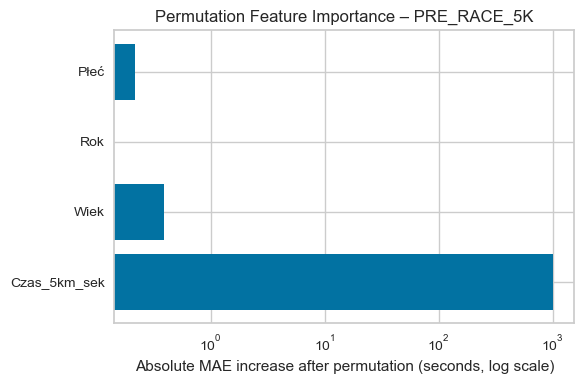

In [24]:
fi_plot = fi.copy()
fi_plot["abs_importance"] = np.abs(fi_plot["importance_mae_drop"])

plt.figure(figsize=(6, 4))

plt.barh(
    fi_plot["feature"],
    fi_plot["abs_importance"]
)

plt.xscale("log")

plt.xlabel("Absolute MAE increase after permutation (seconds, log scale)")
plt.title("Permutation Feature Importance – PRE_RACE_5K")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 9. Zapis artefaktów modelu PRE_RACE_5K

Wytrenowany model oraz wszystkie niezbędne metadane zapisywane są w formie
artefaktów, które mogą być bezpośrednio wykorzystane w aplikacji Streamlit.

### Zapis modelu i artefaktów treningu (lokalnie)

Zapisujemy wytrenowany model oraz komplet artefaktów (schema, metadane, wskaźnik `latest`) do lokalnej struktury katalogów, stanowiącej podstawę do wersjonowania, analizy wyników i dalszego deploymentu.

In [25]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

model_name = f"halfmarathon_pre_race_5k_{ts}"
model_path_prefix = str(OUT_DIR / model_name)

# 1) zapis modelu .pkl
save_model(final_model, model_path_prefix)

# 2) schema.json (kontrakt wejścia pod Streamlit/LLM)
schema = {
    "model_type": "pre_race_5k",
    "target": "Czas_sek",
    "features": {
        "Płeć": {"type": "category", "allowed": ["M", "K"]},
        "Wiek": {"type": "int", "min": RANGES["age_min"], "max": RANGES["age_max"]},
        "Czas_5km_sek": {"type": "int", "format_input": "MM:SS or HH:MM:SS", "min": RANGES["k5_min_sec"], "max": RANGES["k5_max_sec"]},
        "Rok": {"type": "int", "allowed": sorted(model_df["Rok"].unique().tolist())},
    },
    "notes": [
        "Model oczekuje Czas_5km_sek w sekundach; w aplikacji można przyjąć tekst np. '2:12:34' i sparsować time_to_seconds().",
        "Rok można ustawić domyślnie na najnowszy dostępny (np. 2025), bez pytania usera."
    ]
}

schema_path = OUT_DIR / "schema.json"
schema_path.write_text(json.dumps(schema, indent=2, ensure_ascii=False), encoding="utf-8")

# 3) metadata.json
metadata = {
    "timestamp": ts,
    "session_id": SESSION_ID,
    "data": {
        "raw_shape": list(df_raw.shape),
        "clean_shape": list(model_df.shape),
        "train_shape_2023": list(train_df.shape),
        "test_shape_2024": list(test_df.shape),
        "filters": RANGES
    },
    "metrics": {
        "baseline_mae_sec": float(baseline_mae),
        "baseline_rmse_sec": float(baseline_rmse),
        "test2024_mae_sec": float(mae),
        "test2024_rmse_sec": float(rmse),
    },
    "feature_importance": fi.to_dict(orient="records"),
    "model_files": {
        "pycaret_save_prefix": model_name,
        "model_pkl": f"{model_name}.pkl"
    }
}

metadata_path = OUT_DIR / f"metadata_{ts}.json"
metadata_path.write_text(json.dumps(metadata, indent=2, ensure_ascii=False), encoding="utf-8")

# 4) latest.json (aplikacja zawsze będzie ładować latest)
latest = {
    "model_pkl": f"{model_name}.pkl",
    "metadata_json": f"metadata_{ts}.json",
    "schema_json": "schema.json"
}

latest_path = OUT_DIR / "latest.json"
latest_path.write_text(json.dumps(latest, indent=2, ensure_ascii=False), encoding="utf-8")

print("✅ Saved artifacts to:", OUT_DIR.resolve())
print(" -", f"{model_name}.pkl")
print(" -", metadata_path.name)
print(" - schema.json")
print(" - latest.json")


Transformation Pipeline and Model Successfully Saved
✅ Saved artifacts to: A:\AI-Data\AI-Data\m11\runner_app_scc\artifacts\pre_race_5k
 - halfmarathon_pre_race_5k_20260204_123627.pkl
 - metadata_20260204_123627.json
 - schema.json
 - latest.json


### Publikacja artefaktów modelu do DigitalOcean Spaces

Synchronizujemy lokalnie zapisane artefakty modelu z DigitalOcean Spaces, umożliwiając ich wykorzystanie przez aplikację produkcyjną oraz zapewniając trwałe przechowywanie i łatwy rollback wersji modelu.

In [26]:
if ENABLE_DO_UPLOAD:
    print("⬆ Uploading artifacts to DigitalOcean Spaces")

    def upload_artifacts_dir(local_dir: Path, spaces_prefix: str):
        print("📁 Upload z katalogu:", local_dir.resolve())
    
        for file_path in local_dir.iterdir():
            if not file_path.is_file():
                continue
    
            spaces_key = f"{spaces_prefix}/{file_path.name}"
    
            client.upload_file(
                Filename=str(file_path),
                Bucket=BUCKET_NAME,
                Key=spaces_key,
                ExtraArgs={"ACL": "private"},
            )
            print(f"⬆️ {file_path.name} → s3://{BUCKET_NAME}/{spaces_key}")
    
        print(f"✅ Zsynchronizowano: {local_dir.name}")
    
    upload_artifacts_dir(
        local_dir=OUT_DIR,
        spaces_prefix="artifacts/pre_race_5k"
    )

else:
    print("⏭ Skipping DigitalOcean upload (ENABLE_DO_UPLOAD = False)")


⏭ Skipping DigitalOcean upload (ENABLE_DO_UPLOAD = False)


In [27]:
# przykład rekordu usera (po parsowaniu LLM -> dict)
user_row = pd.DataFrame([{
    "Płeć": "M",
    "Wiek": 35,
    "Czas_5km_sek": 1500,  # np. 25:00
    "Rok": 2024
}])

pred = predict_model(final_model, data=user_row)
pred


,Płeć,Wiek,Czas_5km_sek,Rok,prediction_label
0,M,35,1500,2024,6597.436528


## 10. Trenowanie modelu PRE_RACE_10K

Model PRE_RACE_10K rozszerza dane wejściowe o czas na 10 km,
co pozwala na dokładniejszą estymację czasu ukończenia półmaratonu.

Powtarzamy te same kroki jak w przypadku modelu PRE_RACE_5K.

In [28]:
OUT_DIR_10K = Path("artifacts") / "pre_race_10k"
OUT_DIR_10K.mkdir(parents=True, exist_ok=True)

RANGES_10K = {
    **RANGES,
    "k10_min_sec": 1800,   # 30:00
    "k10_max_sec": 7200,   # 120:00
}


In [29]:
# Budowa datasetu PRE_RACE_10K

df10 = df_raw.copy()

# usuń DNS/DNF/DSQ
df10 = df10[~df10["Czas"].astype(str).str.upper().isin(["DNS", "DNF", "DSQ"])].copy()

# target
df10["Czas_sek"] = df10["Czas"].apply(time_to_seconds)

# wejścia
df10["Czas_5km_sek"] = df10["5 km Czas"].apply(time_to_seconds)
df10["Czas_10km_sek"] = df10["10 km Czas"].apply(time_to_seconds)

df10["Rocznik"] = pd.to_numeric(df10["Rocznik"], errors="coerce")
df10["Wiek"] = df10["Rok"] - df10["Rocznik"]
df10["Płeć"] = df10["Płeć"].apply(normalize_sex)

# dropna — tu wymagamy 5km + 10km
df10 = df10.dropna(subset=[
    "Czas_sek", "Czas_5km_sek", "Czas_10km_sek", "Wiek", "Płeć", "Rok"
]).copy()

# filtry jakościowe
df10 = df10[(df10["Wiek"] >= RANGES_10K["age_min"]) & (df10["Wiek"] <= RANGES_10K["age_max"])]
df10 = df10[(df10["Czas_sek"] >= RANGES_10K["hm_min_sec"]) & (df10["Czas_sek"] <= RANGES_10K["hm_max_sec"])]
df10 = df10[(df10["Czas_5km_sek"] >= RANGES_10K["k5_min_sec"]) & (df10["Czas_5km_sek"] <= RANGES_10K["k5_max_sec"])]
df10 = df10[(df10["Czas_10km_sek"] >= RANGES_10K["k10_min_sec"]) & (df10["Czas_10km_sek"] <= RANGES_10K["k10_max_sec"])]

model_df_10k = df10[[
    "Płeć", "Wiek", "Czas_5km_sek", "Czas_10km_sek", "Rok", "Czas_sek"
]].reset_index(drop=True)

print("✅ PRE_RACE_10K shape:", model_df_10k.shape)
model_df_10k.head()


✅ PRE_RACE_10K shape: (17887, 6)


,Płeć,Wiek,Czas_5km_sek,Czas_10km_sek,Rok,Czas_sek
0,M,27.0,946.0,1883.0,2023,4104.0
1,M,35.0,971.0,1930.0,2023,4216.0
2,M,28.0,972.0,1955.0,2023,4227.0
3,M,40.0,969.0,1950.0,2023,4234.0
4,M,24.0,937.0,1885.0,2023,4278.0


In [30]:
# Baseline PRE_RACE_10K

y10 = model_df_10k["Czas_sek"].values
baseline_pred_10k = np.full_like(y10, np.median(y10), dtype=float)

baseline_mae_10k = mean_absolute_error(y10, baseline_pred_10k)
baseline_rmse_10k = np.sqrt(mean_squared_error(y10, baseline_pred_10k))

print(f"Baseline 10K MAE:  {baseline_mae_10k:.2f} s ({baseline_mae_10k/60:.2f} min)")
print(f"Baseline 10K RMSE: {baseline_rmse_10k:.2f} s ({baseline_rmse_10k/60:.2f} min)")

Baseline 10K MAE:  950.85 s (15.85 min)
Baseline 10K RMSE: 1219.20 s (20.32 min)


In [31]:
# Split TRAIN/TEST (2023 → 2024)

train_10k = model_df_10k[model_df_10k["Rok"] == 2023].copy()
test_10k  = model_df_10k[model_df_10k["Rok"] == 2024].copy()

print("Train 10K:", train_10k.shape)
print("Test  10K:", test_10k.shape)

Train 10K: (7904, 6)
Test  10K: (9983, 6)


In [32]:
# PyCaret setup (PRE_RACE_10K)

exp_10k = setup(
    data=train_10k,
    target="Czas_sek",
    session_id=SESSION_ID,

    categorical_features=["Płeć"],
    numeric_features=["Czas_5km_sek", "Czas_10km_sek", "Wiek", "Rok"],

    normalize=True,
    normalize_method="zscore",
    transformation=False,

    fold=5,
    remove_outliers=False,
)


,Description,Value
0,Session id,42
1,Target,Czas_sek
2,Target type,Regression
3,Original data shape,"(7904, 6)"
4,Transformed data shape,"(7904, 6)"
5,Transformed train set shape,"(5532, 6)"
6,Transformed test set shape,"(2372, 6)"
7,Numeric features,4
8,Categorical features,1
9,Preprocess,True


In [33]:
top_10k = compare_models(sort="MAE", n_select=3)
top_10k

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,169.0661,67546.9547,259.0048,0.9538,0.0326,0.0220,0.0260
par,Passive Aggressive Regressor,169.8188,68193.8171,260.1780,0.9533,0.0328,0.0221,0.0240
lr,Linear Regression,172.4264,66523.5387,257.1214,0.9545,0.0325,0.0225,0.0220
lar,Least Angle Regression,172.4264,66523.5387,257.1214,0.9545,0.0325,0.0225,0.0220
br,Bayesian Ridge,172.4426,66523.2032,257.1214,0.9545,0.0325,0.0225,0.0260
ridge,Ridge Regression,172.7954,66530.8794,257.1488,0.9545,0.0325,0.0226,0.0360
llar,Lasso Least Angle Regression,173.6002,66682.1659,257.4649,0.9544,0.0326,0.0227,0.0240
lasso,Lasso Regression,173.6318,66689.7857,257.4804,0.9544,0.0326,0.0227,0.0220
lightgbm,Light Gradient Boosting Machine,183.3301,73911.3571,271.1146,0.9494,0.0344,0.0241,0.1120
rf,Random Forest Regressor,185.6447,75876.2687,274.8996,0.9480,0.0349,0.0243,0.2120


[HuberRegressor(),
 PassiveAggressiveRegressor(random_state=42),
 LinearRegression(n_jobs=-1)]

In [34]:
best_10k = top_10k[0]

tuned_10k = tune_model(best_10k, optimize="MAE")
tuned_10k

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,172.6499,71336.8009,267.0895,0.9503,0.0336,0.0225
1,168.6166,63232.8648,251.4615,0.9554,0.0323,0.0220
2,176.2367,87022.1994,294.9953,0.9420,0.0374,0.0226
3,167.8739,60674.7372,246.3224,0.9607,0.0304,0.0217
4,161.4382,54391.3947,233.2196,0.9613,0.0296,0.0211
Mean,169.3631,67331.5994,258.6177,0.9539,0.0326,0.0220
Std,4.9725,11245.6543,21.1780,0.0072,0.0027,0.0006


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


HuberRegressor()

In [35]:
final_10k = finalize_model(tuned_10k)

pred_10k = predict_model(final_10k, data=test_10k)

y_true_10k = test_10k["Czas_sek"].values
y_pred_10k = pred_10k["prediction_label"].values

mae_10k = mean_absolute_error(y_true_10k, y_pred_10k)
rmse_10k = np.sqrt(mean_squared_error(y_true_10k, y_pred_10k))

print(f"✅ PRE_RACE_10K Test MAE:  {mae_10k:.2f} s ({mae_10k/60:.2f} min)")
print(f"✅ PRE_RACE_10K Test RMSE: {rmse_10k:.2f} s ({rmse_10k/60:.2f} min)")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,167.4423,69694.6067,263.9974,0.9521,0.0325,0.0215


✅ PRE_RACE_10K Test MAE:  167.44 s (2.79 min)
✅ PRE_RACE_10K Test RMSE: 264.00 s (4.40 min)


Dodanie na wejściu deklarowanej wartości czasu na 10 km zdecydowanie poprawia zdolności predykcyjne modelu.

In [36]:
X_test_10k = test_10k.drop(columns=["Czas_sek"])
y_test_10k = test_10k["Czas_sek"]

perm_10k = permutation_importance(
    final_10k,
    X_test_10k,
    y_test_10k,
    n_repeats=10,
    random_state=SESSION_ID,
    scoring="neg_mean_absolute_error"
)

fi_10k = pd.DataFrame({
    "feature": X_test_10k.columns,
    "importance_mae_drop": perm_10k.importances_mean * -1
}).sort_values("importance_mae_drop", ascending=False)

fi_10k


,feature,importance_mae_drop
1,Wiek,0.058954
4,Rok,-0.000000
0,Płeć,-0.840330
2,Czas_5km_sek,-1160.132561
3,Czas_10km_sek,-2459.332998


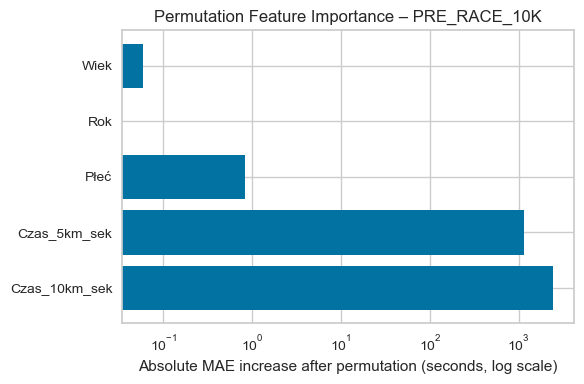

In [37]:
fi10_plot = fi_10k.copy()
fi10_plot["abs_importance"] = np.abs(fi10_plot["importance_mae_drop"])

plt.figure(figsize=(6, 4))

plt.barh(
    fi10_plot["feature"],
    fi10_plot["abs_importance"]
)

plt.xscale("log")

plt.xlabel("Absolute MAE increase after permutation (seconds, log scale)")
plt.title("Permutation Feature Importance – PRE_RACE_10K")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Wynik funkcji permutacji (skala logarytmiczna) pokazuje, że czas 10 km jest dominującym czynnikiem prognostycznym, a czas 5 km dostarcza dodatkowych informacji, podczas gdy wiek, płeć i rok mają marginalny wpływ.

In [38]:
ts10 = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name_10k = f"halfmarathon_pre_race_10k_{ts10}"
model_prefix_10k = str(OUT_DIR_10K / model_name_10k)

# model
save_model(final_10k, model_prefix_10k)

# schema
schema_10k = {
    "model_type": "pre_race_10k",
    "target": "Czas_sek",
    "features": {
        "Płeć": {"type": "category", "allowed": ["M", "K"]},
        "Wiek": {"type": "int", "min": RANGES_10K["age_min"], "max": RANGES_10K["age_max"]},
        "Czas_5km_sek": {"type": "int", "format_input": "MM:SS"},
        "Czas_10km_sek": {"type": "int", "format_input": "MM:SS"},
        "Rok": {"type": "int", "allowed": sorted(model_df_10k["Rok"].unique().tolist())},
    }
}

(OUT_DIR_10K / "schema.json").write_text(
    json.dumps(schema_10k, indent=2, ensure_ascii=False), encoding="utf-8"
)

# metadata
metadata_10k = {
    "timestamp": ts10,
    "data_shape": {
        "clean": list(model_df_10k.shape),
        "train_2023": list(train_10k.shape),
        "test_2024": list(test_10k.shape),
    },
    "metrics": {
        "baseline_mae_sec": float(baseline_mae_10k),
        "test_mae_sec": float(mae_10k),
        "test_rmse_sec": float(rmse_10k),
    },
    "feature_importance": fi_10k.to_dict(orient="records"),
    "model_file": f"{model_name_10k}.pkl"
}

metadata_path_10k = OUT_DIR_10K / f"metadata_{ts10}.json"
metadata_path_10k.write_text(
    json.dumps(metadata_10k, indent=2, ensure_ascii=False), encoding="utf-8"
)

# latest
latest_10k = {
    "model_pkl": f"{model_name_10k}.pkl",
    "metadata_json": f"metadata_{ts10}.json",
    "schema_json": "schema.json"
}

(OUT_DIR_10K / "latest.json").write_text(
    json.dumps(latest_10k, indent=2, ensure_ascii=False), encoding="utf-8"
)

print("✅ PRE_RACE_10K artifacts saved to:", OUT_DIR_10K.resolve())


Transformation Pipeline and Model Successfully Saved
✅ PRE_RACE_10K artifacts saved to: A:\AI-Data\AI-Data\m11\runner_app_scc\artifacts\pre_race_10k


In [39]:
if ENABLE_DO_UPLOAD:
    print("⬆ Uploading artifacts to DigitalOcean Spaces")

    upload_artifacts_dir(
        local_dir=OUT_DIR_10K,
        spaces_prefix="artifacts/pre_race_10k"
    )

else:
    print("⏭ Skipping DigitalOcean upload (ENABLE_DO_UPLOAD = False)")

⏭ Skipping DigitalOcean upload (ENABLE_DO_UPLOAD = False)


In [40]:
# Logika wyboru modelu (pod aplikację)

def select_model_input(user_dict):
    """
    Jeśli user poda 10km → model 10k
    W przeciwnym razie → model 5k
    """
    return "pre_race_10k" if "Czas_10km_sek" in user_dict else "pre_race_5k"


## 11. Podsumowanie

W ramach niniejszego notebooka zaimplementowano kompletny pipeline treningowy
do predykcji czasu ukończenia półmaratonu na podstawie danych dostępnych przed startem biegu.

### Wytrenowane modele

Wyeliminowano ryzyko wycieku danych poprzez konsekwentne używanie wyłącznie cech,
które są znane przed rozpoczęciem zawodów. Na tej podstawie wytrenowano dwa
komplementarne modele predykcyjne:

#### PRE_RACE_5K
Model przeznaczony do użycia w sytuacji, gdy dostępne są jedynie podstawowe informacje
o zawodniku:
- płeć,
- wiek,
- czas uzyskany na dystansie 5 km.

Model ten zapewnia stabilną i realistyczną estymację czasu ukończenia półmaratonu
przy minimalnych wymaganiach dotyczących danych wejściowych.  
Na danych testowych z edycji 2024 osiągnięto średni błąd bezwzględny (MAE)
na poziomie około **5 minut**, co stanowi istotną poprawę względem modelu bazowego.

#### PRE_RACE_10K
Drugi model rozszerza zbiór cech wejściowych o czas uzyskany na dystansie 10 km:
- płeć,
- wiek,
- czas na 5 km,
- czas na 10 km.

Dodatkowa informacja o dłuższym dystansie pozwala na precyzyjniejsze odwzorowanie
tempa zawodnika oraz jego zdolności do utrzymania wysiłku w czasie.
Model ten osiąga wyraźnie niższy błąd predykcji niż wariant PRE_RACE_5K
i będzie automatycznie wykorzystywany w aplikacji, gdy użytkownik poda wymagane dane.

### Walidacja i interpretowalność

Oba modele zostały zwalidowane w układzie czasowym (trening na danych z 2023 roku,
test na danych z 2024 roku), co odzwierciedla rzeczywisty scenariusz użycia
w przyszłych edycjach biegu.

Analiza istotności cech potwierdziła, że modele opierają się głównie na informacjach
o tempie biegu (czasy na 5 km i 10 km), natomiast wpływ wieku i płci ma charakter
korekcyjny, a zmienna „rok” nie wnosi istotnego sygnału predykcyjnego.
Jest to zgodne z wiedzą domenową i potwierdza poprawność przyjętej metodologii.

### Artefakty wyjściowe

Dla każdego modelu zapisano komplet artefaktów:
- wytrenowany model w formacie `.pkl`,
- plik `schema.json` opisujący wymagany kontrakt danych wejściowych,
- plik `metadata.json` zawierający metryki jakości, zakresy danych treningowych
  oraz informacje kontekstowe,
- plik `latest.json` wskazujący aktualną wersję modelu do użycia w aplikacji.

Taki podział umożliwia łatwą wymianę modeli bez konieczności modyfikacji kodu aplikacji.

### Kolejne kroki

Wytrenowane modele stanowią bezpośrednią podstawę do budowy aplikacji predykcyjnej.
W następnym etapie zostaną one:
- opakowane w aplikację Streamlit,
- zintegrowane z modułem ekstrakcji danych wejściowych opartym o model językowy (LLM),
- objęte monitoringiem jakości ekstrakcji danych przy użyciu Langfuse.